## CASE STUDY ONE: Weather Sensor Analysis with RandomForest Regression

### Import modules integrated into spark Kafka and Delta Lake

In [3]:
import os
import findspark
import pyspark

SCALA_VERSION = '2.12'
SPARK_VERSION = '3.3.0'

os.environ['PYSPARK_SUBMIT_ARGS'] = f'--packages org.apache.spark:spark-sql-kafka-0-10_{SCALA_VERSION}:{SPARK_VERSION},
org.apache.spark:spark-avro_2.12:3.3.2,io.delta:delta-core_2.12:2.2.0 
--conf "spark.sql.extensions=io.delta.sql.DeltaSparkSessionExtension" 
--conf "spark.sql.catalog.spark_catalog=org.apache.spark.sql.delta.catalog.DeltaCatalog" 
--conf spark.driver.extraJavaOptions=-Djdk.logger.allowReflection=true 
--conf spark.executor.extraJavaOptions=-Djdk.logger.allowReflection=true pyspark-shell'

#findspark.init()


### Import pyspark libraries 

#### To start up spark session, define schema and data type

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

spark = SparkSession.builder \
    .appName("KafkaStream") \
    .getOrCreate()

#Set Spark logging level to ERROR to avoid various other logs on console.
spark.sparkContext.setLogLevel("ERROR")
spark.sql("set spark.sql.streaming.schemaInference=true")


#### Spark session created on local port 4040

In [5]:
spark

### Extract weather data with the stream data API

In [2]:
import requests
import json

url = "http://api.openweathermap.org/data/2.5/air_pollution/forecast?lat=52.950001&lon=-1.150000&appid=2d557f868d673c2659a653d495a004dd"
response = requests.get(url)

if response.status_code == 200:
    data = response.json()
    # Do something with the data
else:
    print("Error fetching data from API")

### Kafka Data Ingestion

In [3]:
from kafka import KafkaProducer

# Set up Kafka producer
producer = KafkaProducer(bootstrap_servers=['127.0.0.1:9092'],
                             value_serializer=lambda x: json.dumps(x).encode('utf-8'))

# Send data to Kafka topic
producer.send('weatherdata', data)
producer.flush()

### Structured Streaming DataFrame

In [6]:
df = spark \
    .readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "127.0.0.1:9092") \
    .option("subscribe", "weatherdata") \
    .option("startingOffsets", "earliest") \
    .load() 


In [2]:
df.printSchema()

In [7]:
df = df.selectExpr("CAST(value AS STRING)","timestamp")

In [8]:
schema = "array<struct<main:struct<aqi:int>, components:struct<co:double, no:double, no2:double, o3:double, so2:double, pm2_5:double, pm10:double, nh3:double>, dt:bigint>>"


In [9]:


df_new = df.select(get_json_object(col("value"), "$.coord").alias("coord"),explode(from_json(get_json_object(col("value"),"$.list"), schema)).alias("exploded_col"),"timestamp")


In [10]:
df_n = df_new.select(col("exploded_col.main.aqi").alias("aqi"), 
               col("exploded_col.components.co").alias("co"), 
               col("exploded_col.components.no").alias("no"), 
               col("exploded_col.components.no2").alias("no2"), 
               col("exploded_col.components.o3").alias("o3"), 
               col("exploded_col.components.so2").alias("so2"), 
               col("exploded_col.components.pm2_5").alias("pm2_5"), 
               col("exploded_col.components.pm10").alias("pm10"), 
               col("exploded_col.components.nh3").alias("nh3"), 
               col("exploded_col.dt").alias("dt"),col("timestamp").alias("timestamp"))


In [11]:
# extract hour from timestamp column
df_n = df_n.withColumn("minutes", minute("timestamp"))
df_n = df_n.drop(col("hour"))

In [12]:
window_df_count_sum = df_n.withWatermark("timestamp", "2 hour").groupBy(window(df_n.timestamp, "1 hour")).agg({"co": "count", "no2": "count","co": "sum","aqi": "max"})
            

In [13]:
window_df_max = df_n.groupBy(window(df_n.timestamp, "1 hour")).agg({"aqi": "max"})

In [14]:
import pandas as pd

# Define a function to write each micro-batch to a Pandas DataFrame
def write_to_pandas(df, epoch_id):
    # Convert the Spark DataFrame to a Pandas DataFrame
    pandas_df = df.toPandas()
    # Print the Pandas DataFrame
    display(pandas_df)

In [15]:
# Define the streaming query
streaming_query = window_df_count_sum.writeStream \
    .foreachBatch(write_to_pandas) \
    .outputMode("complete") \
    .start()

,window,count(no2),max(aqi),sum(co)
0,"(2023-04-09 21:00:00, 2023-04-09 22:00:00)",96,3,21285.52


In [16]:
# Define the streaming query
streaming_query = window_df_max.writeStream \
    .foreachBatch(write_to_pandas) \
    .outputMode("complete") \
    .start()


,window,max(aqi)
0,"(2023-04-09 21:00:00, 2023-04-09 22:00:00)",3


In [17]:
df_n.printSchema()

root
 |-- aqi: integer (nullable = true)
 |-- co: double (nullable = true)
 |-- no: double (nullable = true)
 |-- no2: double (nullable = true)
 |-- o3: double (nullable = true)
 |-- so2: double (nullable = true)
 |-- pm2_5: double (nullable = true)
 |-- pm10: double (nullable = true)
 |-- nh3: double (nullable = true)
 |-- dt: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- minutes: integer (nullable = true)



In [18]:
stream_query = df_n.writeStream \
    .outputMode("append") \
    .format("memory") \
    .queryName("my_query") \
    .start()

stream = spark.sql("SELECT * FROM my_query")

In [19]:
from delta.tables import *
# Write the stream to Delta Lake
stream2 =stream.write.format("delta").mode("append").save("/tmp/df_n_table")

# Read the streaming from Delta Lake and display as pandas table
stream3 = spark.read.format("delta").load("/tmp/df_n_table")

# Load Delta table as DataFrame
display(DeltaTable.forPath(spark, "/tmp/df_n_table").toDF().toPandas())


,aqi,co,no,no2,o3,so2,pm2_5,pm10,nh3,dt,timestamp,minutes
0,3,226.97,0.00,7.28,104.43,3.19,9.65,10.43,3.55,1681070400,2023-04-09 21:16:09.481,16
1,3,230.31,0.00,7.28,101.57,3.13,11.05,11.87,3.52,1681074000,2023-04-09 21:16:09.481,16
2,3,233.65,0.00,6.86,100.14,2.68,12.30,13.17,3.45,1681077600,2023-04-09 21:16:09.481,16
3,2,230.31,0.00,6.00,98.71,2.18,13.00,13.88,3.55,1681081200,2023-04-09 21:16:09.481,16
4,2,230.31,0.00,6.08,92.98,2.41,15.75,16.68,3.80,1681084800,2023-04-09 21:16:09.481,16
...,...,...,...,...,...,...,...,...,...,...,...,...
91,2,226.97,1.08,8.23,60.80,2.65,1.13,1.30,0.66,1681225200,2023-04-09 21:16:09.481,16
92,1,226.97,1.23,7.88,58.65,2.62,1.03,1.20,0.74,1681228800,2023-04-09 21:16:09.481,16
93,2,223.64,0.85,6.17,62.23,1.86,0.76,0.90,1.00,1681232400,2023-04-09 21:16:09.481,16
94,2,220.30,0.30,4.50,71.53,1.45,0.83,1.05,1.24,1681236000,2023-04-09 21:16:09.481,16


In [21]:
stream3.printSchema()


root
 |-- aqi: integer (nullable = true)
 |-- co: double (nullable = true)
 |-- no: double (nullable = true)
 |-- no2: double (nullable = true)
 |-- o3: double (nullable = true)
 |-- so2: double (nullable = true)
 |-- pm2_5: double (nullable = true)
 |-- pm10: double (nullable = true)
 |-- nh3: double (nullable = true)
 |-- dt: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- minutes: integer (nullable = true)



In [ ]:
import plotly.io as pio
pio.renderers.default = "iframe"
import plotly.graph_objects as go
import chart_studio.plotly as py
py.sign_in("adeoye.a.kafayat", "51BL1baAC505SzD7FM8A")

In [ ]:
import plotly.express as px
px.colors.qualitative.Plotly;

In [22]:
# Machine learning libararies
from pyspark.ml.feature import *
from pyspark.ml.classification import *
from pyspark.ml.regression import *
from pyspark.ml.evaluation import *
from pyspark.ml.tree import *


In [ ]:
# transformation
# Define the input features and target variable column names
feature_cols = ["co","no","no2","o3","so2","pm2_5","pm10","nh3"]
# Define the VectorAssembler to transform input features into a vector column
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")


In [23]:
# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = stream3.randomSplit([0.7, 0.3])


#### Random Forest Regression

In [27]:
# Define the multinomial Regression model with the features column and target column
# Train a RandomForest model.
rf = RandomForestRegressor(featuresCol="features", labelCol='aqi')


In [28]:
from pyspark.ml import *
# Chain the VectorAssembler, VectorIndexer, and Logistic Regression model into a Pipeline
rf_pipeline = Pipeline(stages=[assembler,rf])


In [29]:

# Fit the Pipeline to the streaming data
rf_pipeline_model = rf_pipeline.fit(trainingData)


In [33]:
# Make predictions on the streaming data using the fitted Pipeline
rf_predictions = rf_pipeline_model.transform(testData)

In [32]:
# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(labelCol='aqi', metricName="rmse")
rmse = evaluator.evaluate(rf_predictions)
print(f"Root Mean Squared Error (MSE) on test data: {rmse}")


Root Mean Squared Error (MSE) on test data: 0.1747352494701839


In [34]:
rfModel = rf_pipeline_model.stages[1]
print(rfModel)  # summary only

RandomForestRegressionModel: uid=RandomForestRegressor_591083c8f70b, numTrees=20, numFeatures=8


In [35]:
# Write the predictions to Delta Lake
rf_predictions.write.format("delta").mode("append").save("/tmp/rf_tableprediction")

# Read the predictions from Delta Lake and display as pandas table
rf_pred_df = spark.read.format("delta").load("/tmp/rf_tableprediction")
display(rf_pred_df.toPandas())


,aqi,co,no,no2,o3,so2,pm2_5,pm10,nh3,dt,timestamp,minutes,features,prediction
0,2,213.62,0.00,3.21,72.24,1.25,1.15,1.86,2.25,1681174800,2023-04-09 21:16:09.481,16,"[213.62, 0.0, 3.21, 72.24, 1.25, 1.15, 1.86, 2...",2.000
1,2,213.62,0.00,3.38,72.24,1.40,1.16,1.91,2.09,1681182000,2023-04-09 21:16:09.481,16,"[213.62, 0.0, 3.38, 72.24, 1.4, 1.16, 1.91, 2.09]",2.000
2,2,216.96,0.00,3.47,70.81,1.30,1.31,2.10,2.31,1681171200,2023-04-09 21:16:09.481,16,"[216.96, 0.0, 3.47, 70.81, 1.3, 1.31, 2.1, 2.31]",2.000
3,2,216.96,0.00,3.60,72.24,1.54,1.28,2.02,2.00,1681185600,2023-04-09 21:16:09.481,16,"[216.96, 0.0, 3.6, 72.24, 1.54, 1.28, 2.02, 2.0]",2.000
4,2,220.30,0.30,4.50,71.53,1.45,0.83,1.05,1.24,1681236000,2023-04-09 21:16:09.481,16,"[220.3, 0.3, 4.5, 71.53, 1.45, 0.83, 1.05, 1.24]",2.000
5,2,223.64,0.35,8.40,69.38,2.65,1.27,2.00,1.87,1681196400,2023-04-09 21:16:09.481,16,"[223.64, 0.35, 8.4, 69.38, 2.65, 1.27, 2.0, 1.87]",2.000
6,2,223.64,0.61,8.65,73.67,3.16,1.36,2.11,1.65,1681207200,2023-04-09 21:16:09.481,16,"[223.64, 0.61, 8.65, 73.67, 3.16, 1.36, 2.11, ...",2.000
7,2,223.64,0.85,6.17,62.23,1.86,0.76,0.90,1.00,1681232400,2023-04-09 21:16:09.481,16,"[223.64, 0.85, 6.17, 62.23, 1.86, 0.76, 0.9, 1.0]",2.000
8,1,233.65,0.00,14.74,46.49,3.07,4.60,5.04,1.66,1681344000,2023-04-09 21:16:09.481,16,"[233.65, 0.0, 14.74, 46.49, 3.07, 4.6, 5.04, 1...",1.275
9,1,233.65,0.00,18.34,41.84,2.80,4.13,4.60,1.74,1681340400,2023-04-09 21:16:09.481,16,"[233.65, 0.0, 18.34, 41.84, 2.8, 4.13, 4.6, 1.74]",1.225


In [38]:
display(rf_pred_df.select("aqi","minutes","prediction").toPandas().head(10))

,aqi,minutes,prediction
0,2,16,2.000
1,2,16,2.000
2,2,16,2.000
3,2,16,2.000
4,2,16,2.000
5,2,16,2.000
6,2,16,2.000
7,2,16,2.000
8,1,16,1.275
9,1,16,1.225


In [5]:
# plot the prediction vs actual value
pred_df = rf_pred_df.toPandas().head(1000)

# Create a scatter plot of AQI vs prediction
fig = go.Figure()
fig.add_trace(go.Scatter(x=pred_df.index, y=pred_df['aqi'], mode='lines', name='AQI'))
fig.add_trace(go.Scatter(x=pred_df.index, y=pred_df['prediction'], mode='lines', name='Prediction'))

# Add titles and axis labels
fig.update_layout(title='AQI vs Prediction', xaxis_title='Time', yaxis_title='Value')

# Show the plot
fig.show()

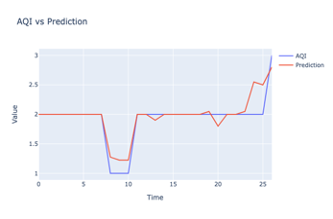

###### Random Forest Evaluation with RMSE, Rsquared and MAE

In [ ]:
# Define the evaluation metric
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="aqi", metricName="rmse")

# Calculate the evaluation metrics for the test data
rmse = evaluator.evaluate(rf_predictions, {evaluator.metricName: "rmse"})
r2 = evaluator.evaluate(rf_predictions, {evaluator.metricName: "r2"})
mae = evaluator.evaluate(rf_predictions, {evaluator.metricName: "mae"})

# Print the evaluation metrics
print("RMSE = %g" % rmse)
print("R-squared = %g" % r2)
print("MAE = %g" % mae)